In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Chapter 11

## 11.1 Data cannot speak for themselves

In [46]:
df1 = pd.DataFrame({
    'A': [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    'Y': [200, 150, 220, 110, 50, 180, 90, 170, 170, 30, 70, 110, 80, 50, 10, 20],
})

### Figure 11.1

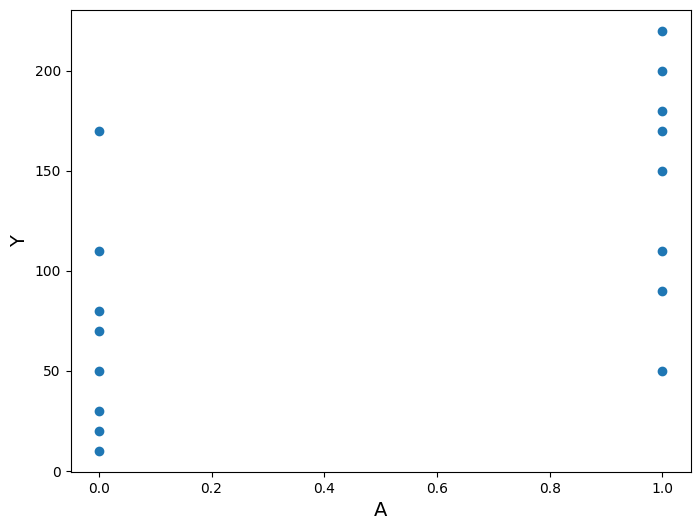

In [47]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.scatter(df1['A'], df1['Y'])
ax.set_xlabel('A', fontsize=14)
ax.set_ylabel('Y', fontsize=14);

In [48]:
df1.groupby('A').describe()

Y                                                     
  count    mean        std   min    25%    50%    75%    max
A                                                           
0   8.0   67.50  53.117121  10.0   27.5   60.0   87.5  170.0
1   8.0  146.25  58.294205  50.0  105.0  160.0  185.0  220.0

In [49]:
df2 = pd.DataFrame({
    'A': [
        1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4
    ],
    'Y': [
        110, 80, 50, 40, 170, 30, 70, 50, 110, 50, 180, 130, 200, 150, 220, 210
    ]
})

### Figure 11.2

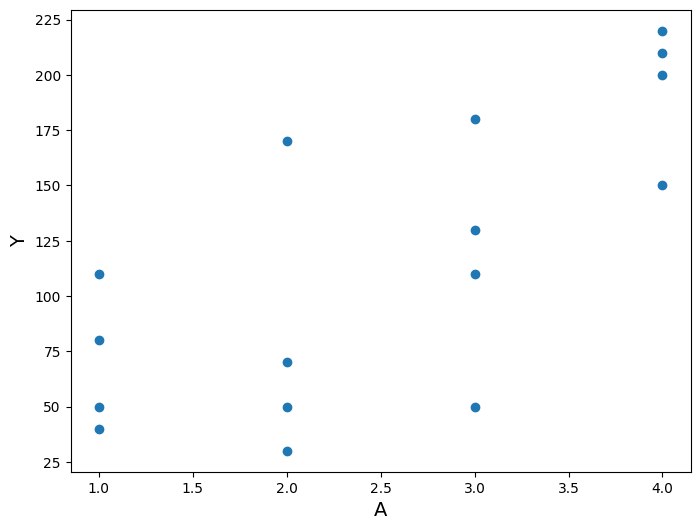

In [50]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.scatter(df2['A'], df2['Y'])
ax.set_xlabel('A', fontsize=14)
ax.set_ylabel('Y', fontsize=14);

In [51]:
df2.groupby('A').describe()

Y                                                     
  count   mean        std    min    25%    50%    75%    max
A                                                           
1   4.0   70.0  31.622777   40.0   47.5   65.0   87.5  110.0
2   4.0   80.0  62.182527   30.0   45.0   60.0   95.0  170.0
3   4.0  117.5  53.774219   50.0   95.0  120.0  142.5  180.0
4   4.0  195.0  31.091264  150.0  187.5  205.0  212.5  220.0

"Finally, suppose that treatment is a variable representing the dose of treatment in mg/day, and that it takes integer values from 0 to 100 mg."

In [52]:
A3 = np.array([3, 11, 17, 23, 29, 37, 41, 53, 67, 79, 83, 97, 60, 71, 15, 45])
Y3 = np.array([21, 54, 33, 101, 85, 65, 157, 120, 111, 200, 140, 220, 230, 217, 11, 190])

In [53]:
df3 = pd.DataFrame({'A': A3, 'Y': Y3, 'constant': np.ones(16)})

### Figure 11.3

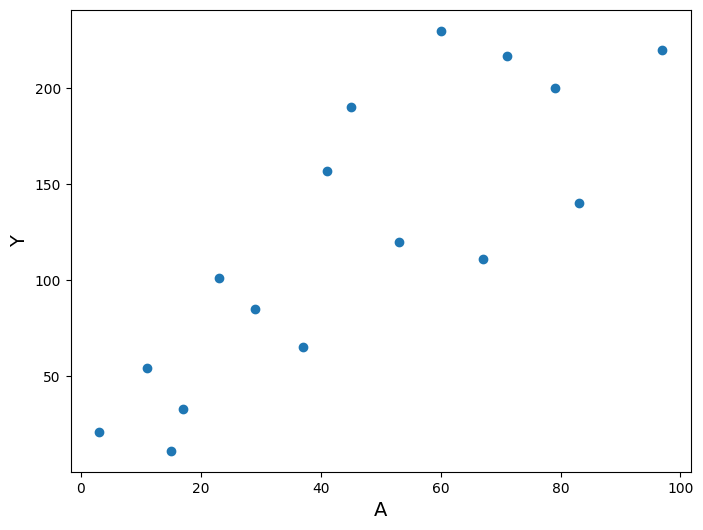

In [54]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.scatter(df3.A, df3.Y)
ax.set_xlabel('A', fontsize=14)
ax.set_ylabel('Y', fontsize=14);

## 11.2 Parametric estimators of the conditional mean

#### statsmodels

In [63]:
X = sm.add_constant(df3['A'])  # adds intercept
model = sm.OLS(df3['Y'], X).fit()
#print(model.summary())
ci = model.conf_int(alpha=0.05)
print(ci)
print(model.params['const'], model.params['A'])

               0          1
const -21.201868  70.294605
A       1.279899   2.994405
24.546368720822134 2.1371519842227715


#### sklearn

In [ ]:
from sklearn.linear_model import LinearRegression

model_sk = LinearRegression()
X = df3[['A']]  # needs to be 2D
y = df3['Y']
model_sk.fit(X, y)

print(model_sk.intercept_, model_sk.coef_)

24.546368720822144 [2.13715198]


#### statistics

In [57]:
from statistics import linear_regression

A = df3['A']
Y = df3['Y']
slope, intercept = linear_regression(A, Y)

print(f"Intercept: {intercept:.2f}, Slope: {slope:.2f}")

Intercept: 24.55, Slope: 2.14


#### scipy

In [58]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Predictor and response
x = df3['A'].values
y = df3['Y'].values

# Fit linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
y_pred = intercept + slope * x
intercept, slope

(np.float64(24.546368720822144), np.float64(2.137151984222771))

### Figure 11.4

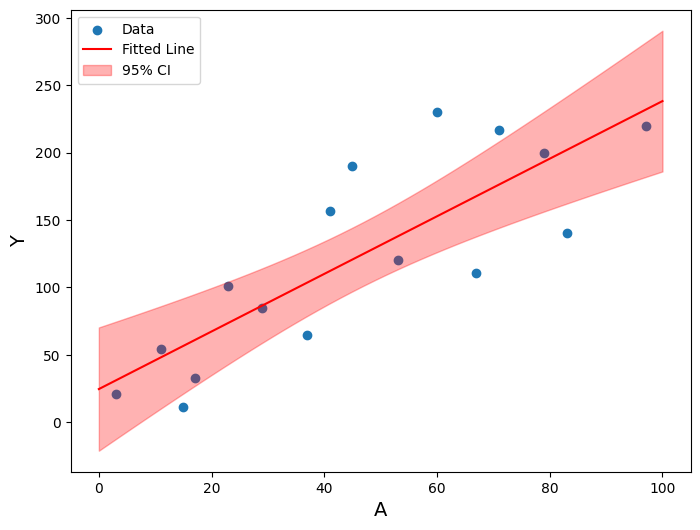

In [64]:
# Generate prediction points
#x_pred = np.linspace(df3['A'].min(), df3['A'].max(), 100)
x_pred = np.linspace(0, 100)
X_pred = sm.add_constant(x_pred)
predictions = model.get_prediction(X_pred)
pred_summary = predictions.summary_frame(alpha=0.05)

# Plotting
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(df3['A'], df3['Y'], label='Data')
ax.plot(x_pred, pred_summary['mean'], color='red', label='Fitted Line')
ax.fill_between(x_pred, pred_summary['mean_ci_lower'], pred_summary['mean_ci_upper'], color='red', alpha=0.3, label='95% CI')
ax.set_xlabel('A', fontsize=14)
ax.set_ylabel('Y', fontsize=14)
ax.legend()
plt.show()

In [65]:
# 95% CI for coefficients
theta0_ci = tuple(model.conf_int().loc['const'].round(1))
theta1_ci = tuple(model.conf_int().loc['A'].round(2))

# 95% CI for E[Y | A = 90]
ey_90_summary = model.get_prediction([[1, 90]]).summary_frame()
ey_90 = ey_90_summary['mean'].iloc[0]
ey_90_ci = ey_90_summary[['mean_ci_lower', 'mean_ci_upper']].iloc[0]

print(f"E[Y | A = 90] estimate: {ey_90:.1f}")
print(f"E[Y | A = 90] 95% CI: ({ey_90_ci.iloc[0]:.1f}, {ey_90_ci.iloc[1]:.1f})")

E[Y | A = 90] estimate: 216.9
E[Y | A = 90] 95% CI: (172.1, 261.6)


### 11.3 Nonparametric estimators of the conditional mean

In [69]:
df1['constant'] = 1
ols = sm.OLS(df1['Y'], df1[['constant', 'A']])
res = ols.fit()
res.summary().tables[1]

c:\Users\TCAR0044\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:418: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=16 observations were given.
  return hypotest_fun_in(*args, **kwds)


,coef,std err,t,P>|t|,[0.025,0.975]
constant,67.5000,19.716,3.424,0.004,25.213,109.787
A,78.7500,27.883,2.824,0.014,18.947,138.553


In [72]:
est_at_0 = res.params['constant']
est_at_1 = res.params['constant'] + res.params['A']
print("E[Y|A=0] est.: {:>6.2f}".format(est_at_0))
print("E[Y|A=1] est.: {:>6.2f}".format(est_at_1))


E[Y|A=0] est.:  67.50
E[Y|A=1] est.: 146.25


## 11.4 Smoothing

In [73]:
# --- Fit quadratic regression model: E[Y | A] = θ₀ + θ₁A + θ₂A² ---

import statsmodels.api as sm

df3['A^2'] = df3['A'] ** 2
model_quad = sm.OLS(df3.Y, df3[['constant', 'A', 'A^2']]).fit()
theta = model_quad.params.round(2)
print(theta)

constant   -7.41
A           4.11
A^2        -0.02
dtype: float64


In [74]:
# --- Predict expected value and 95% CI at A = 90 ---

a_val = 90
exog = [[1, a_val, a_val ** 2]]
pred = model_quad.get_prediction(exog=exog)
pred_summary = pred.summary_frame(alpha=0.05)

ey_90 = pred_summary['mean'].iloc[0]
ci_ey_90 = pred_summary[['mean_ci_lower', 'mean_ci_upper']].iloc[0]

print(f"\nE[Y | A = 90] estimate: {ey_90:.1f}")
print(f"95% CI for E[Y | A = 90]: ({ci_ey_90.iloc[0]:.1f}, {ci_ey_90.iloc[1]:.1f})")


E[Y | A = 90] estimate: 197.1
95% CI for E[Y | A = 90]: (142.8, 251.5)


#### Figure 11.5

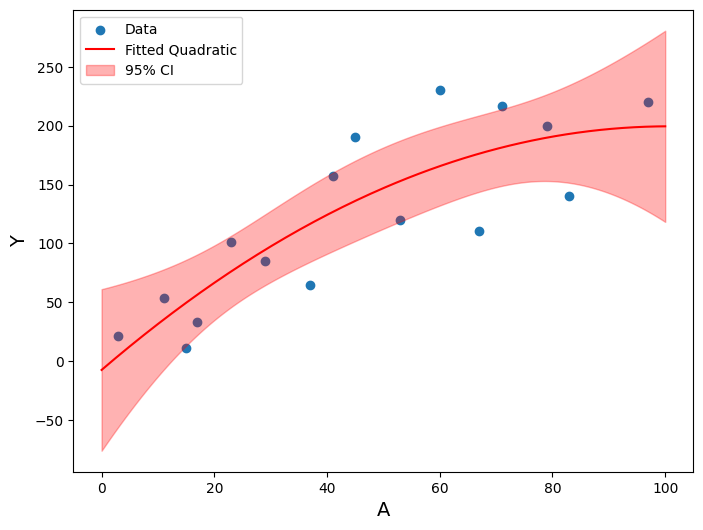

In [75]:
# --- Plot fitted quadratic regression curve with 95% CI ---

# Generate prediction grid
x_pred = np.linspace(0, 100, 200)
X_pred = pd.DataFrame({
    'A': x_pred,
    'A^2': x_pred ** 2,
})
X_pred = sm.add_constant(X_pred)

# Get predictions and confidence intervals
pred = model_quad.get_prediction(X_pred)
pred_summary = pred.summary_frame(alpha=0.05)

# Plot
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(df3['A'], df3['Y'], label='Data')
ax.plot(x_pred, pred_summary['mean'], color='red', label='Fitted Quadratic')
ax.fill_between(x_pred, pred_summary['mean_ci_lower'], pred_summary['mean_ci_upper'],
                color='red', alpha=0.3, label='95% CI')
ax.set_xlabel('A', fontsize=14)
ax.set_ylabel('Y', fontsize=14)
ax.legend()
plt.show()